In [ ]:
#importing libraries
!pip install -U datasets tiktoken tqdm numpy torch matplotlib huggingface_hub
import os
import math
import time
from contextlib import nullcontext
from dataclasses import dataclass, field
from tqdm.auto import tqdm
import json
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
import tiktoken
from datasets import load_dataset
import matplotlib.pyplot as plt

In [ ]:
#tokenization implementation
from datasets import load_dataset
import numpy as np
from tqdm.auto import tqdm
import os
import tiktoken 
import math


enc = tiktoken.get_encoding("gpt2")
eot_token = enc.eot_token

In [ ]:
def processing_bpe(sample):
    text_data = sample.get('text', '')
    if not isinstance(text_data, str): text_data = ""
    ids = enc.encode_ordinary(text_data)
    ids.append(eot_token)
    out = {'ids': ids, 'len': len(ids)}
    return out
combined_data_dir = config.data_dir
os.makedirs(combined_data_dir, exist_ok=True)
train_filename = os.path.join(combined_data_dir, 'train_combined.bin')
val_filename = os.path.join(combined_data_dir, 'val_combined.bin')

In [ ]:
#tokenizer with data splits..
if os.path.exists(train_filename) and os.path.exists(val_filename):
    print(f"Combined .bin files already exist in {combined_data_dir}. Skipping processing.")

else:
    ts_df = load_dataset("roneneldan/TinyStories")
    bc_df = load_dataset("rojagtap/bookcorpus", split='train')
    
    ts_split = ts_df['train'].train_test_split(test_size=0.01, seed=42)
    ts_train_df = ts_split['train']
    ts_val_df = ts_split['test']
    
    bc_split = bc_df.train_test_split(test_size=0.01, seed=42)
    bc_train_df = bc_split['train']
    bc_val_df = bc_split['test']

    dataset_splits = {
        'train': {'ts': ts_train_df, 'bc': bc_train_df},
        'validation': {'ts': ts_val_df, 'bc': bc_val_df}
    }

    for split in ['train', 'validation']:
        filename = train_filename if split == 'train' else val_filename
        
        if os.path.exists(filename):
            os.remove(filename)

        tokenized_ts = dataset_splits[split]['ts'].map(
            processing_bpe, remove_columns=['text'],
            desc=f"Tokenizing TinyStories {split}", num_proc=config.num_proc
        )
        
        tokenized_bc = dataset_splits[split]['bc'].map(
            processing_bpe, remove_columns=['text'],
            desc=f"Tokenizing BookCorpus {split}", num_proc=config.num_proc
        )

        ts_len = np.sum(tokenized_ts['len'], dtype=np.uint64)
        bc_len = np.sum(tokenized_bc['len'], dtype=np.uint64)
        arr_len = ts_len + bc_len

        if arr_len == 0:
            print(f"Warning: No tokens found for combined {split} split. Skipping."); continue
            
        print(f"Total tokens for {split}: {arr_len:,} (TinyStories: {ts_len:,}, BookCorpus: {bc_len:,})")
        dtype_np = np.uint16
        arr = np.memmap(filename, dtype=dtype_np, mode='w+', shape=(arr_len,))
        
        print(f"Writing {ts_len:,} TinyStories tokens to {filename}...")
        idx = 0
        write_batch_size = 1000 # Docs per chunk
        
        total_samples_ts = len(tokenized_ts)
        num_write_batches_ts = math.ceil(total_samples_ts / write_batch_size)
        for i in tqdm(range(num_write_batches_ts), desc=f"Writing TinyStories {split}"):
            start = i * write_batch_size; end = min((i + 1) * write_batch_size, total_samples_ts)
            chunk = tokenized_ts.select(range(start, end))
            try:
                all_ids_in_chunk = [item['ids'] for item in chunk if item['ids']]
                if not all_ids_in_chunk: continue
                arr_batch = np.concatenate(all_ids_in_chunk).astype(dtype_np)
                batch_len = len(arr_batch)
                expected_end_idx = idx + batch_len
                if expected_end_idx > arr_len: print(f"Error: Bounds overflow (TS). Stopping."); break
                arr[idx : expected_end_idx] = arr_batch; idx = expected_end_idx
            except Exception as e: print(f"Error writing TS chunk {i}: {e}"); break
        
        
        total_samples_bc = len(tokenized_bc)
        num_write_batches_bc = math.ceil(total_samples_bc / write_batch_size)
        
        for i in tqdm(range(num_write_batches_bc), desc=f"Writing BookCorpus {split}"):
            start = i * write_batch_size; end = min((i + 1) * write_batch_size, total_samples_bc)
            chunk = tokenized_bc.select(range(start, end))
            try:
                all_ids_in_chunk = [item['ids'] for item in chunk if item['ids']]
                if not all_ids_in_chunk: continue
                arr_batch = np.concatenate(all_ids_in_chunk).astype(dtype_np)
                batch_len = len(arr_batch)
                expected_end_idx = idx + batch_len
                if expected_end_idx > arr_len: print(f"Error: Bounds overflow (BC). Stopping."); break
                arr[idx : expected_end_idx] = arr_batch; idx = expected_end_idx
            except Exception as e: print(f"Error writing BC chunk {i}: {e}"); break

        arr.flush()
        if idx != arr_len:
             print(f"Warning: Final index {idx} doesn't match expected {arr_len}.")
        else:
            print(f"Successfully wrote {idx} total tokens.")
        print(f"Finished writing {filename}.")

In [ ]:
#memap files
import numpy as np
import torch
import os
train_data_file = os.path.join(config.data_dir, 'train_combined.bin')
val_data_file = os.path.join(config.data_dir, 'val_combined.bin')
if not os.path.exists(train_data_file) or not os.path.exists(val_data_file):
     raise FileNotFoundError(f"Combined .bin files not found in {config.data_dir}. Did Cell 3 complete?")

train_data = np.memmap(train_data_file, dtype=np.uint16, mode='r')
val_data = np.memmap(val_data_file, dtype=np.uint16, mode='r')

print(f"Train data loaded: {len(train_data):,} tokens")
print(f"Validation data loaded: {len(val_data):,} tokens")

In [ ]:
#batch function
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - config.block_size, (config.batch_size,))
    
    x = torch.stack([torch.from_numpy((data[i:i+config.block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+config.block_size]).astype(np.int64)) for i in ix])
    
    if config.device == 'cuda':
        x, y = x.pin_memory().to(config.device, non_blocking=True), y.pin_memory().to(config.device, non_blocking=True)
    else:
        x, y = x.to(config.device), y.to(config.device)
    return x, y

try:
    x_batch, y_batch = get_batch('train')
    
    x_val, y_val = get_batch('val')
    print(f"Validation batch x shape: {x_val.shape}")
    print(f"Validation batch y shape: {y_val.shape}")
except Exception as e:
    print(f"Error testing get_batch: {e}")

In [ ]:
#model setup

import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from contextlib import nullcontext
from dataclasses import dataclass, field # Import field

@dataclass
class SLMConfig:
    block_size: int = 256; vocab_size: int = 50257
    n_layer: int = 12; n_head: int = 12; n_embd: int = 768
    dropout: float = 0.1; bias: bool = False
    # Add other fields with defaults from Cell 2 if needed
    batch_size: int = 8; gradient_accumulation_steps: int = 4
    max_iters: int = 100000; eval_interval: int = 1000
    eval_iters: int = 200; learning_rate: float = 3e-4
    weight_decay: float = 0.1; beta1: float = 0.9; beta2: float = 0.95
    grad_clip: float = 1.0; warmup_iters: int = 2000
    lr_decay_iters: int = 100000; min_lr: float = 3e-5
    device: str = 'cuda'; dtype: str = 'bfloat16'; compile: bool = True
    data_dir: str = 'data_combined'; num_proc: int = 8; total_batches: int = 1024
    out_dir: str = 'out_v3'; best_model_name: str = 'best_model_v3.pt'
    local_pretrained_path: str = ""

if 'config' not in locals(): raise NameError("Config object 'config' not found. Please re-run Cell 2.")
if 'ptdtype' not in locals(): ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[config.dtype]
ctx = nullcontext() if config.device == 'cpu' else torch.amp.autocast(device_type=config.device, dtype=ptdtype)


class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: Flash Attention 2.0 not available.")
        # Causal mask
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        is_training = self.training
        dropout_val = self.dropout if is_training else 0.0

        if self.flash and not is_training:
             try: y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=0.0, is_causal=True)
             except Exception: self.flash = False; 
        if not self.flash or is_training:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            current_T = min(T, self.bias.size(-1))
            att = att.masked_fill(self.bias[:,:,:current_T,:current_T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1);
            if dropout_val > 0.0: att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        proj_output = self.c_proj(y)
        if dropout_val > 0.0: y = self.resid_dropout(proj_output)
        else: y = proj_output
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        x = self.c_fc(x); x = self.gelu(x); x = self.c_proj(x)
        if self.training: x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__(); self.ln_1 = LayerNorm(config.n_embd, bias=config.bias); self.attn = CausalSelfAttention(config); self.ln_2 = LayerNorm(config.n_embd, bias=config.bias); self.mlp = MLP(config)
    def forward(self, x): x = x + self.attn(self.ln_1(x)); x = x + self.mlp(self.ln_2(x)); return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None; assert config.block_size is not None
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # Weight tying
        
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None: torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device; b, t = idx.size();
        if t > self.config.block_size: idx = idx[:, -self.config.block_size:]; t = self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)
        tok_emb = self.transformer.wte(idx); pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb) if self.training else tok_emb + pos_emb
        for block in self.transformer.h: x = block(x)
        x = self.transformer.ln_f(x)
        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else: logits = self.lm_head(x[:, [-1], :]); loss = None
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        self.eval()
        enc = tiktoken.get_encoding("gpt2")
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None: v, _ = torch.topk(logits, min(top_k, logits.size(-1))); logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1); idx_next = torch.multinomial(probs, num_samples=1)
            if idx_next == enc.eot_token: break
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

model = GPT(config) 

model.to(config.device)

if config.compile:
    print("compiling")
    try:
        model = torch.compile(model)
        print("Model compiled.")
    except Exception as e:
        print(f"torch.compile failed: {e}. Proceeding without compilation.")
        config.compile = False

In [ ]:
#adam optimizer and lr scheduler

from torch.optim.lr_scheduler import LambdaLR

if 'model' not in locals():
    raise NameError("Model not defined. Please re-run Cell 5.")
decay_params = []
no_decay_params = []
for pn, p in model.named_parameters():
    if p.requires_grad:
        if p.dim() >= 2:
            decay_params.append(p)
        else:
            no_decay_params.append(p)

param_groups = [
    {'params': decay_params, 'weight_decay': config.weight_decay},
    {'params': no_decay_params, 'weight_decay': 0.0}
]
num_decay_params = sum(p.numel() for p in decay_params)
num_nodecay_params = sum(p.numel() for p in no_decay_params)

optimizer = torch.optim.AdamW(
    param_groups,
    lr=config.learning_rate, 
    betas=(config.beta1, config.beta2),
    eps=1e-8
)

def get_lr_multiplier(it):
    if it < config.warmup_iters:
        return float(it) / float(max(1, config.warmup_iters))
    if it > config.lr_decay_iters:
        return config.min_lr / config.learning_rate
    decay_ratio = (it - config.warmup_iters) / (config.lr_decay_iters - config.warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    multiplier = (config.min_lr + coeff * (config.learning_rate - config.min_lr)) / config.learning_rate
    return multiplier

lr_scheduler = LambdaLR(optimizer, lr_lambda=get_lr_multiplier)

In [ ]:
#training loop with gradient accumulation


if 'get_batch' not in globals():
     raise NameError("get_batch function not defined. Please run Cell 4.")
if 'config' not in locals() or 'ptdtype' not in locals() or 'ctx' not in locals():
     raise NameError("'config', 'ptdtype', or 'ctx' not defined. Run previous cells.")
if 'optimizer' not in locals() or 'lr_scheduler' not in locals():
     raise NameError("'optimizer' or 'lr_scheduler' not defined. Run Cell 6.")
if 'estimate_loss' not in globals():
     raise NameError("'estimate_loss' not defined. Run Cell 7.")

gradient_accumulation_steps = config.gradient_accumulation_steps
if gradient_accumulation_steps <= 0:
    gradient_accumulation_steps = 1 # Ensure it's at least 1
print(f"Using gradient accumulation steps: {gradient_accumulation_steps}")

scaler = torch.amp.GradScaler('cuda', enabled=(config.dtype == 'float16'))

train_loss_list_v3 = []
val_loss_list_v3 = []
initial_val_loss = initial_losses.get('val', torch.tensor(float('inf')))
best_val_loss = initial_val_loss.item() if not torch.isnan(initial_val_loss) else float('inf')

start_time = time.time()
# Initialize optimizer gradient just in case
optimizer.zero_grad(set_to_none=True) 

for it in range(config.max_iters):

    # --- Periodically Evaluate ---
    if it % config.eval_interval == 0 or it == config.max_iters - 1 or it == 0:
        actual_eval_iters = config.eval_iters
        losses = estimate_loss(model, actual_eval_iters, config.device, ctx)
        current_time = time.time(); elapsed_time = current_time - start_time
        current_lr = optimizer.param_groups[0]['lr']
        train_loss_val = losses.get('train', torch.tensor(float('nan')))
        val_loss_val = losses.get('val', torch.tensor(float('nan')))
        train_loss_str = f"{train_loss_val:.4f}" if not torch.isnan(train_loss_val) else "NaN"
        val_loss_str = f"{val_loss_val:.4f}" if not torch.isnan(val_loss_val) else "NaN"

        print(f"Step {it:6d} | Train Loss: {train_loss_str} | Val Loss: {val_loss_str} | LR: {current_lr:.6f} | Time: {elapsed_time:.2f}s")

        if not torch.isnan(train_loss_val): train_loss_list_v3.append(train_loss_val.item())
        if not torch.isnan(val_loss_val): val_loss_list_v3.append(val_loss_val.item())

        if not torch.isnan(val_loss_val) and val_loss_val.item() < best_val_loss:
            best_val_loss = val_loss_val.item()
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'config': asdict(config), # Save config as dict
                'iter': it,
                'best_val_loss': best_val_loss,
            }
            print(f"  -> Val loss improved from {best_val_loss:.4f} to {val_loss_val.item():.4f}. Saving checkpoint...")
            try:
                torch.save(checkpoint, best_model_path) # best_model_path from Cell 2
                print(f"   Checkpoint saved to {best_model_path}")
            except Exception as e:
                print(f"   Error saving checkpoint: {e}")

    for micro_step in range(gradient_accumulation_steps):
        try:
            X, Y = get_batch('train')
        except Exception as e:
            print(f"Error getting batch at step {it}, micro_step {micro_step}: {e}"); continue
        
        with ctx:
            logits, loss = model(X, Y)
            loss = loss / gradient_accumulation_steps 
        
        if torch.isnan(loss):
            continue 
        scaler.scale(loss).backward()

    if config.grad_clip > 0.0:
        scaler.unscale_(optimizer) # Unscale before clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
    
    scaler.step(optimizer)
    scaler.update()
    
    optimizer.zero_grad(set_to_none=True)
    
    lr_scheduler.step()

end_time = time.time()
print("\n--- V3 Pre-training Complete ---")
print(f"Total time: {(end_time - start_time)/60:.2f} minutes")
if best_val_loss == float('inf'): print("No valid best validation loss recorded.")
else: print(f"Best validation loss achieved: {best_val_loss:.4f}")

Using gradient accumulation steps: 4
Initializing best_val_loss to: 11.0000
Starting training for 100000 iterations...
Step      0 | Train Loss: 11.0000 | Val Loss: 11.0000 | LR: 0.000000 | Time: 22.22s
Step   1000 | Train Loss: 4.5938 | Val Loss: 4.5938 | LR: 0.000150 | Time: 842.09s
  -> Val loss improved from 4.5938 to 4.5938. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step   2000 | Train Loss: 3.9844 | Val Loss: 4.0312 | LR: 0.000300 | Time: 1656.08s
  -> Val loss improved from 4.0312 to 4.0312. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step   3000 | Train Loss: 3.7656 | Val Loss: 3.7188 | LR: 0.000300 | Time: 2477.06s
  -> Val loss improved from 3.7188 to 3.7188. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step   4000 | Train Loss: 3.5781 | Val Loss: 3.5938 | LR: 0.000300 | Time: 3295.82s
  -> Val loss improved from 3.5938 to 3.5938. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step   5000 | Train Loss: 3.5312 | Val Loss: 3.5000 | LR: 0.000299 | Time: 4121.51s
  -> Val loss improved from 3.5000 to 3.5000. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step   6000 | Train Loss: 3.4688 | Val Loss: 3.4531 | LR: 0.000299 | Time: 4945.68s
  -> Val loss improved from 3.4531 to 3.4531. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step   7000 | Train Loss: 3.4531 | Val Loss: 3.4531 | LR: 0.000298 | Time: 5773.21s
Step   8000 | Train Loss: 3.4062 | Val Loss: 3.3906 | LR: 0.000298 | Time: 6578.49s
  -> Val loss improved from 3.3906 to 3.3906. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step   9000 | Train Loss: 3.3594 | Val Loss: 3.3594 | LR: 0.000297 | Time: 7390.34s
  -> Val loss improved from 3.3594 to 3.3594. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  10000 | Train Loss: 3.3125 | Val Loss: 3.3594 | LR: 0.000296 | Time: 8201.33s
Step  11000 | Train Loss: 3.2812 | Val Loss: 3.3281 | LR: 0.000294 | Time: 9010.95s
  -> Val loss improved from 3.3281 to 3.3281. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  12000 | Train Loss: 3.3438 | Val Loss: 3.2656 | LR: 0.000293 | Time: 9795.86s
  -> Val loss improved from 3.2656 to 3.2656. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  13000 | Train Loss: 3.2656 | Val Loss: 3.2812 | LR: 0.000292 | Time: 10595.66s
Step  14000 | Train Loss: 3.2500 | Val Loss: 3.2188 | LR: 0.000290 | Time: 11485.11s
  -> Val loss improved from 3.2188 to 3.2188. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  15000 | Train Loss: 3.2969 | Val Loss: 3.2656 | LR: 0.000288 | Time: 12460.12s
Step  16000 | Train Loss: 3.2344 | Val Loss: 3.2031 | LR: 0.000287 | Time: 13415.72s
  -> Val loss improved from 3.2031 to 3.2031. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  17000 | Train Loss: 3.2344 | Val Loss: 3.2344 | LR: 0.000285 | Time: 14289.98s
Step  18000 | Train Loss: 3.2031 | Val Loss: 3.1719 | LR: 0.000283 | Time: 15160.89s
  -> Val loss improved from 3.1719 to 3.1719. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  19000 | Train Loss: 3.1875 | Val Loss: 3.2031 | LR: 0.000280 | Time: 16024.75s
Step  20000 | Train Loss: 3.2031 | Val Loss: 3.2031 | LR: 0.000278 | Time: 16941.32s
Step  21000 | Train Loss: 3.2031 | Val Loss: 3.1719 | LR: 0.000276 | Time: 17906.12s
Step  22000 | Train Loss: 3.1406 | Val Loss: 3.1719 | LR: 0.000273 | Time: 18898.45s
Step  23000 | Train Loss: 3.1406 | Val Loss: 3.1719 | LR: 0.000271 | Time: 19861.49s
Step  24000 | Train Loss: 3.1562 | Val Loss: 3.1406 | LR: 0.000268 | Time: 20825.00s
  -> Val loss improved from 3.1406 to 3.1406. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  25000 | Train Loss: 3.1562 | Val Loss: 3.1562 | LR: 0.000265 | Time: 21804.86s
Step  26000 | Train Loss: 3.0938 | Val Loss: 3.1562 | LR: 0.000262 | Time: 22804.84s
Step  27000 | Train Loss: 3.1875 | Val Loss: 3.1250 | LR: 0.000259 | Time: 23808.41s
  -> Val loss improved from 3.1250 to 3.1250. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  28000 | Train Loss: 3.1250 | Val Loss: 3.1406 | LR: 0.000256 | Time: 24828.07s
Step  29000 | Train Loss: 3.1250 | Val Loss: 3.1250 | LR: 0.000253 | Time: 25797.07s
Step  30000 | Train Loss: 3.0781 | Val Loss: 3.0781 | LR: 0.000249 | Time: 26805.60s
  -> Val loss improved from 3.0781 to 3.0781. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  31000 | Train Loss: 3.1406 | Val Loss: 3.1094 | LR: 0.000246 | Time: 27896.45s
Step  32000 | Train Loss: 3.0938 | Val Loss: 3.0781 | LR: 0.000242 | Time: 28859.89s
Step  33000 | Train Loss: 3.1250 | Val Loss: 3.0781 | LR: 0.000239 | Time: 29629.99s
Step  34000 | Train Loss: 3.0781 | Val Loss: 3.0938 | LR: 0.000235 | Time: 30402.28s
Step  35000 | Train Loss: 3.1250 | Val Loss: 3.0781 | LR: 0.000231 | Time: 31175.06s
Step  36000 | Train Loss: 3.1094 | Val Loss: 3.0938 | LR: 0.000227 | Time: 31947.80s
Step  37000 | Train Loss: 3.0625 | Val Loss: 3.0938 | LR: 0.000224 | Time: 32721.14s
Step  38000 | Train Loss: 3.0625 | Val Loss: 3.0625 | LR: 0.000220 | Time: 33494.00s
  -> Val loss improved from 3.0625 to 3.0625. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  39000 | Train Loss: 3.1094 | Val Loss: 3.0781 | LR: 0.000216 | Time: 34268.12s
Step  40000 | Train Loss: 3.0625 | Val Loss: 3.1250 | LR: 0.000212 | Time: 35042.76s
Step  41000 | Train Loss: 3.0312 | Val Loss: 3.0781 | LR: 0.000208 | Time: 35817.89s
Step  42000 | Train Loss: 3.0469 | Val Loss: 3.0625 | LR: 0.000203 | Time: 36594.54s
Step  43000 | Train Loss: 3.0312 | Val Loss: 3.0469 | LR: 0.000199 | Time: 37369.47s
  -> Val loss improved from 3.0469 to 3.0469. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  44000 | Train Loss: 3.0469 | Val Loss: 3.0938 | LR: 0.000195 | Time: 38147.14s
Step  45000 | Train Loss: 3.0469 | Val Loss: 3.0781 | LR: 0.000191 | Time: 38928.20s
Step  46000 | Train Loss: 3.0781 | Val Loss: 3.0781 | LR: 0.000187 | Time: 39708.15s
Step  47000 | Train Loss: 3.0469 | Val Loss: 3.0781 | LR: 0.000182 | Time: 40487.42s
Step  48000 | Train Loss: 3.0156 | Val Loss: 3.1094 | LR: 0.000178 | Time: 41269.54s
Step  49000 | Train Loss: 3.0312 | Val Loss: 3.0469 | LR: 0.000174 | Time: 42046.33s
Step  50000 | Train Loss: 2.9844 | Val Loss: 3.0469 | LR: 0.000169 | Time: 42821.40s
Step  51000 | Train Loss: 3.0469 | Val Loss: 3.0781 | LR: 0.000165 | Time: 43598.10s
Step  52000 | Train Loss: 3.0312 | Val Loss: 3.0312 | LR: 0.000161 | Time: 44377.59s
  -> Val loss improved from 3.0312 to 3.0312. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  53000 | Train Loss: 3.0000 | Val Loss: 3.0312 | LR: 0.000156 | Time: 45158.59s
Step  54000 | Train Loss: 3.0156 | Val Loss: 3.0469 | LR: 0.000152 | Time: 45941.50s
Step  55000 | Train Loss: 3.0156 | Val Loss: 3.0312 | LR: 0.000148 | Time: 46725.17s
Step  56000 | Train Loss: 3.0312 | Val Loss: 3.0781 | LR: 0.000143 | Time: 47507.60s
Step  57000 | Train Loss: 3.0625 | Val Loss: 3.0156 | LR: 0.000139 | Time: 48292.61s
  -> Val loss improved from 3.0156 to 3.0156. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  58000 | Train Loss: 3.0156 | Val Loss: 3.0312 | LR: 0.000135 | Time: 49079.20s
Step  59000 | Train Loss: 3.0156 | Val Loss: 3.0156 | LR: 0.000131 | Time: 49861.42s
Step  60000 | Train Loss: 3.0469 | Val Loss: 3.0469 | LR: 0.000127 | Time: 50640.45s
Step  61000 | Train Loss: 3.0156 | Val Loss: 3.0625 | LR: 0.000122 | Time: 51417.22s
Step  62000 | Train Loss: 3.0000 | Val Loss: 3.0312 | LR: 0.000118 | Time: 52194.85s
Step  63000 | Train Loss: 3.0000 | Val Loss: 2.9688 | LR: 0.000114 | Time: 52970.24s
  -> Val loss improved from 2.9688 to 2.9688. Saving checkpoint...
   Checkpoint saved to out_v3/best_model_v3.pt
Step  64000 | Train Loss: 3.0000 | Val Loss: 3.0469 | LR: 0.000110 | Time: 53748.13s
Step  65000 | Train Loss: 3.0312 | Val Loss: 2.9844 | LR: 0.000106 | Time: 54523.57s
Step  66000 | Train Loss: 3.0469 | Val Loss: 3.0312 | LR: 0.000103 | Time: 55300.06s
Step  67000 | Train Loss: 3.0469 | Val Loss: 3.0000 | LR: 0.000099 | Time: 56076.09s
Step  68000 | Train Loss: 2.9844 | Val Loss: 3.0000 | LR: 0.000095 | Time: 56852.66s
Step  69000 | Train Loss: 3.0000 | Val Loss: 3.0469 | LR: 0.000091 | Time: 57629.19s
Step  70000 | Train Loss: 3.0625 | Val Loss: 3.0312 | LR: 0.000088 | Time: 58404.47s
Step  71000 | Train Loss: 3.0000 | Val Loss: 3.0312 | LR: 0.000084 | Time: 59179.44s
Step  72000 | Train Loss: 3.0312 | Val Loss: 3.0156 | LR: 0.000081 | Time: 59955.59s
Step  73000 | Train Loss: 3.0469 | Val Loss: 3.0156 | LR: 0.000077 | Time: 60730.39s
Step  74000 | Train Loss: 2.9844 | Val Loss: 2.9688 | LR: 0.000074 | Time: 61504.59s
Step  75000 | Train Loss: 2.9844 | Val Loss: 2.9844 | LR: 0.000071 | Time: 62279.40s
Step  76000 | Train Loss: 2.9844 | Val Loss: 3.0156 | LR: 0.000068 | Time: 63052.62s
Step  77000 | Train Loss: 3.0156 | Val Loss: 3.0156 | LR: 0.000065 | Time: 63825.37s
Step  78000 | Train Loss: 3.0312 | Val Loss: 3.0000 | LR: 0.000062 | Time: 64598.61s
Step  79000 | Train Loss: 3.0469 | Val Loss: 2.9844 | LR: 0.000059 | Time: 65371.89s
Step  80000 | Train Loss: 3.0000 | Val Loss: 3.0469 | LR: 0.000057 | Time: 66145.94s
Step  81000 | Train Loss: 2.9688 | Val Loss: 2.9844 | LR: 0.000054 | Time: 66919.85s
Step  82000 | Train Loss: 2.9688 | Val Loss: 3.0469 | LR: 0.000052 | Time: 67693.88s
Step  83000 | Train Loss: 3.0312 | Val Loss: 3.0312 | LR: 0.000050 | Time: 68469.56s
Step  84000 | Train Loss: 3.0000 | Val Loss: 3.0312 | LR: 0.000047 | Time: 69242.97s
Step  85000 | Train Loss: 3.0312 | Val Loss: 3.0156 | LR: 0.000045 | Time: 70016.58s
Step  86000 | Train Loss: 3.0000 | Val Loss: 3.0156 | LR: 0.000043 | Time: 70790.21s
Step  87000 | Train Loss: 2.9688 | Val Loss: 3.0312 | LR: 0.000042 | Time: 71562.06s
Step  88000 | Train Loss: 3.0156 | Val Loss: 3.0000 | LR: 0.000040 | Time: 72333.70s
Step  89000 | Train Loss: 3.0000 | Val Loss: 2.9688 | LR: 0.000038 | Time: 73106.02s
Step  90000 | Train Loss: 3.0625 | Val Loss: 2.9688 | LR: 0.000037 | Time: 73874.55s
Step  91000 | Train Loss: 3.0312 | Val Loss: 3.0312 | LR: 0.000036 | Time: 74641.63s
Step  92000 | Train Loss: 3.0000 | Val Loss: 2.9844 | LR: 0.000034 | Time: 75411.81s
Step  93000 | Train Loss: 2.9688 | Val Loss: 3.0000 | LR: 0.000033 | Time: 76187.39s
Step  94000 | Train Loss: 3.0000 | Val Loss: 3.0000 | LR: 0.000032 | Time: 76960.16s
Step  95000 | Train Loss: 2.9844 | Val Loss: 3.0312 | LR: 0.000032 | Time: 77728.03s
Step  96000 | Train Loss: 3.0000 | Val Loss: 3.0000 | LR: 0.000031 | Time: 78501.28s
Step  97000 | Train Loss: 2.9688 | Val Loss: 3.0000 | LR: 0.000031 | Time: 79273.19s
Step  98000 | Train Loss: 3.0312 | Val Loss: 3.0000 | LR: 0.000030 | Time: 80046.06s
Step  99000 | Train Loss: 2.9844 | Val Loss: 3.0156 | LR: 0.000030 | Time: 80819.30s
Step  99999 | Train Loss: 3.0312 | Val Loss: 3.0469 | LR: 0.000030 | Time: 81591.22s

--- V3 Pre-training Complete ---
Total time: 1359.86 minutes
Best validation loss achieved: 2.9688

In [ ]:
#plots

import matplotlib.pyplot as plt
import os
import numpy as np 


if 'train_loss_list_v3' not in locals() or 'val_loss_list_v3' not in locals():
     raise NameError("Loss lists (train_loss_list_v3/val_loss_list_v3) not found.")
if 'config' not in locals():
     raise NameError("Config object not found. Please run Cell 2.")


eval_interval = config.eval_interval
steps = [i * eval_interval for i in range(len(train_loss_list_v3))]

train_losses = train_loss_list_v3[:len(steps)]
val_losses = val_loss_list_v3[:len(steps)]

plt.figure(figsize=(12, 6))
plt.plot(steps, train_losses, 'g-o', label='train loss', markersize=3, alpha=0.7) #
plt.plot(steps, val_losses, 'r-o', label='val loss', markersize=3, alpha=0.7)
plt.xlabel(f"Training Steps")
plt.ylabel("Loss")

all_losses_except_first = train_losses[1:] + val_losses[1:]
if all_losses_except_first:
    min_loss = min(all_losses_except_first)
    max_loss = max(all_losses_except_first)
    plt.ylim(bottom=min_loss - 0.1, top=max_loss + 0.1)
else:
    min_loss = min(train_losses + val_losses) if (train_losses + val_losses) else 0
    max_loss = max(train_losses + val_losses) if (train_losses + val_losses) else 11
    plt.ylim(bottom=min_loss - 0.2, top=max_loss + 0.2)
    
    
plt.legend()
plt.title("V2 Model Pre-training Loss (TinyStories + BookCorpus)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


major_ticks = np.arange(0, config.max_iters + 1, 10000)
minor_ticks = np.arange(0, config.max_iters + 1, 5000)
ax = plt.gca()
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.xticks(rotation=30)

plt.tight_layout()

plot_filename = os.path.join(config.out_dir, "loss_plot_v3.png")
try:
    plt.savefig(plot_filename)
    print(f"Loss plot saved to {plot_filename}")
except Exception as e:
    print(f"Error saving plot: {e}")

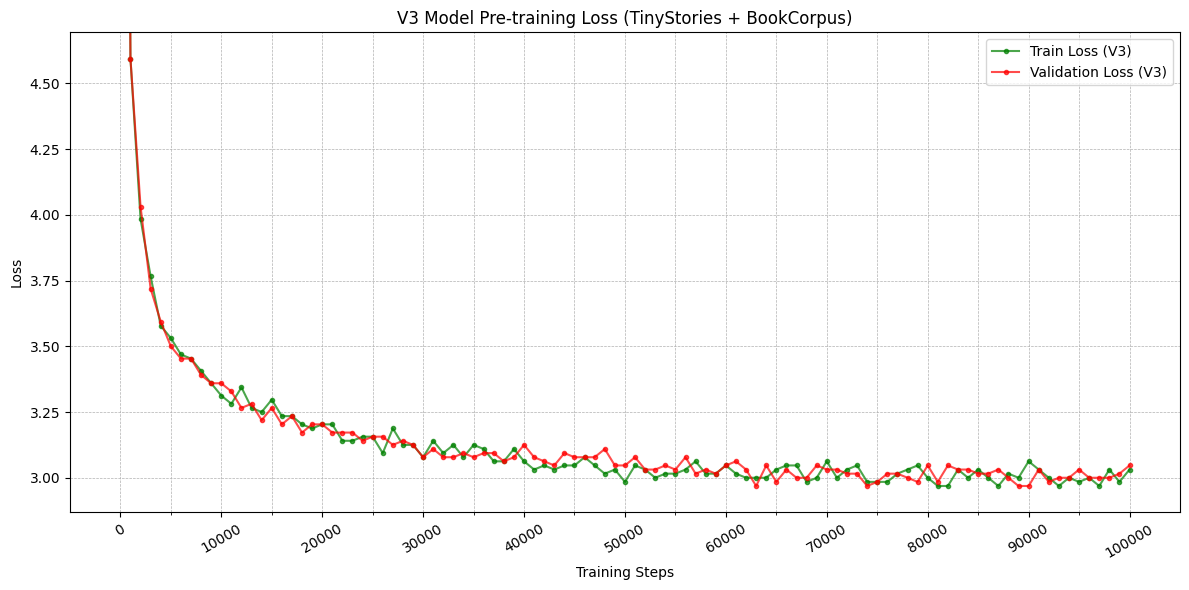

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from contextlib import nullcontext
from dataclasses import dataclass, field
import math

if 'model' not in locals() or 'config' not in locals():
    print("Model or config not found. Loading from checkpoint...")
    @dataclass
    class SLMConfig:
        block_size: int = 256; vocab_size: int = 50257
        n_layer: int = 12; n_head: int = 12; n_embd: int = 768
        dropout: float = 0.1; bias: bool = False
        device: str = 'cuda'; dtype: str = 'bfloat16'; compile: bool = True

    class LayerNorm(nn.Module):
        def __init__(self, ndim, bias): super().__init__(); self.weight = nn.Parameter(torch.ones(ndim)); self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
        def forward(self, x): return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

    class CausalSelfAttention(nn.Module):
        def __init__(self, config):
            super().__init__(); assert config.n_embd % config.n_head == 0
            self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias); self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
            self.attn_dropout = nn.Dropout(config.dropout); self.resid_dropout = nn.Dropout(config.dropout)
            self.n_head = config.n_head; self.n_embd = config.n_embd; self.dropout = config.dropout
            self.flash = hasattr(F, 'scaled_dot_product_attention')
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))
        def forward(self, x):
            B, T, C = x.size(); q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
            k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2); q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2); v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
            is_training = self.training; dropout_val = self.dropout if is_training else 0.0
            if self.flash and not is_training:
                 try: y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=0.0, is_causal=True)
                 except Exception: self.flash = False; # Fallthrough
            if not self.flash or is_training:
                att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
                current_T = min(T, self.bias.size(-1)); att = att.masked_fill(self.bias[:,:,:current_T,:current_T] == 0, float('-inf'))
                att = F.softmax(att, dim=-1);
                if dropout_val > 0.0: att = self.attn_dropout(att)
                y = att @ v
            y = y.transpose(1, 2).contiguous().view(B, T, C); proj_output = self.c_proj(y)
            if dropout_val > 0.0: y = self.resid_dropout(proj_output)
            else: y = proj_output
            return y

    class MLP(nn.Module):
        def __init__(self, config):
            super().__init__(); self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
            self.gelu = nn.GELU(approximate='tanh'); self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
            self.dropout = nn.Dropout(config.dropout)
        def forward(self, x):
            x = self.c_fc(x); x = self.gelu(x); x = self.c_proj(x)
            if self.training: x = self.dropout(x)
            return x

    class Block(nn.Module):
        def __init__(self, config): super().__init__(); self.ln_1 = LayerNorm(config.n_embd, bias=config.bias); self.attn = CausalSelfAttention(config); self.ln_2 = LayerNorm(config.n_embd, bias=config.bias); self.mlp = MLP(config)
        def forward(self, x): x = x + self.attn(self.ln_1(x)); x = x + self.mlp(self.ln_2(x)); return x

    class GPT(nn.Module):
        def __init__(self, config):
            super().__init__(); assert config.vocab_size == 50257; assert config.block_size is not None; self.config = config
            self.transformer = nn.ModuleDict(dict(wte = nn.Embedding(config.vocab_size, config.n_embd), wpe = nn.Embedding(config.block_size, config.n_embd), drop = nn.Dropout(config.dropout), h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), ln_f = LayerNorm(config.n_embd, bias=config.bias)))
            self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False); self.transformer.wte.weight = self.lm_head.weight
        def get_num_params(self, non_embedding=True): return sum(p.numel() for p in self.parameters())
        def _init_weights(self, module):
            if isinstance(module, nn.Linear): torch.nn.init.normal_(module.weight, mean=0.0, std=0.02);
            if module.bias is not None: torch.nn.init.zeros_(module.bias)
            elif isinstance(module, nn.Embedding): torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        def forward(self, idx, targets=None):
             device = idx.device; b, t = idx.size();
             if t > self.config.block_size: idx = idx[:, -self.config.block_size:]; t = self.config.block_size
             pos = torch.arange(0, t, dtype=torch.long, device=device); tok_emb = self.transformer.wte(idx); pos_emb = self.transformer.wpe(pos)
             x = self.transformer.drop(tok_emb + pos_emb) if self.training else tok_emb + pos_emb
             for block in self.transformer.h: x = block(x)
             x = self.transformer.ln_f(x)
             if targets is not None: logits = self.lm_head(x); loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
             else: logits = self.lm_head(x[:, [-1], :]); loss = None
             return logits, loss
        @torch.no_grad()
        def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
            self.eval()
            enc = tiktoken.get_encoding("gpt2")
            for _ in range(max_new_tokens):
                idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
                logits, _ = self(idx_cond); logits = logits[:, -1, :] / temperature
                if top_k is not None: v, _ = torch.topk(logits, min(top_k, logits.size(-1))); logits[logits < v[:, [-1]]] = -float('Inf')
                probs = F.softmax(logits, dim=-1); idx_next = torch.multinomial(probs, num_samples=1)
                if idx_next == enc.eot_token: break
                idx = torch.cat((idx, idx_next), dim=1)
            return idx
    if 'best_model_path' not in locals(): 
        if 'config' not in locals(): config = SLMConfig()
        best_model_path = os.path.join(config.out_dir, config.best_model_name)
        
    print(f"Loading best V3 model from {best_model_path} for plotting...")
    checkpoint = torch.load(best_model_path, map_location='cpu', weights_only=False)
    
    config_to_load = None
    if 'config' in checkpoint:
        saved_config_data = checkpoint['config']
        if isinstance(saved_config_data, dict):
             config_fields = {f.name for f in SLMConfig.__dataclass_fields__.values()}
             filtered_args = {k: v for k, v in saved_config_data.items() if k in config_fields}
             for f_name, f_field in SLMConfig.__dataclass_fields__.items():
                 has_default = hasattr(f_field, 'default') and f_field.default is not None
                 if f_name not in filtered_args and has_default: filtered_args[f_name] = f_field.default
             try: config_to_load = SLMConfig(**filtered_args)
             except Exception: pass # Fallback
        elif isinstance(saved_config_data, SLMConfig): config_to_load = saved_config_data
    if config_to_load is None: config_to_load = config
    
    model = GPT(config_to_load)
    state_dict = checkpoint['model']; uncompiled_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(uncompiled_state_dict, strict=False)
    model.to(config.device); model.eval()
    print("Model loaded for plotting.")


print("Plotting weight histograms...")
model.eval()

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Weight Distributions (V3 Model)', fontsize=16)

weights_wte = model.transformer.wte.weight.detach().cpu().float().numpy()
axs[0, 0].hist(weights_wte.flatten(), bins=100, log=True) # Use log scale for large layers
axs[0, 0].set_title("transformer.wte (Token Embeddings)")
axs[0, 0].set_xlabel("Weight Value")
axs[0, 0].set_ylabel("Frequency (Log Scale)")

weights_attn = model.transformer.h[-1].attn.c_proj.weight.detach().cpu().float().numpy()
axs[0, 1].hist(weights_attn.flatten(), bins=100)
axs[0, 1].set_title("transformer.h[-1].attn.c_proj (Last Block)")
axs[0, 1].set_xlabel("Weight Value")
axs[0, 1].set_ylabel("Frequency")

weights_mlp = model.transformer.h[-1].mlp.c_proj.weight.detach().cpu().float().numpy()
axs[1, 0].hist(weights_mlp.flatten(), bins=100)
axs[1, 0].set_title("transformer.h[-1].mlp.c_proj (Last Block)")
axs[1, 0].set_xlabel("Weight Value")
axs[1, 0].set_ylabel("Frequency")

weights_lmhead = model.lm_head.weight.detach().cpu().float().numpy()
axs[1, 1].hist(weights_lmhead.flatten(), bins=100, log=True)
axs[1, 1].set_title("lm_head (Output Layer)")
axs[1, 1].set_xlabel("Weight Value")
axs[1, 1].set_ylabel("Frequency (Log Scale)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_filename = os.path.join(config.out_dir, "weights_histogram_v3.png")
try:
    plt.savefig(plot_filename)
    print(f"Weights histogram saved to {plot_filename}")
except Exception as e:
    print(f"Error saving plot: {e}")

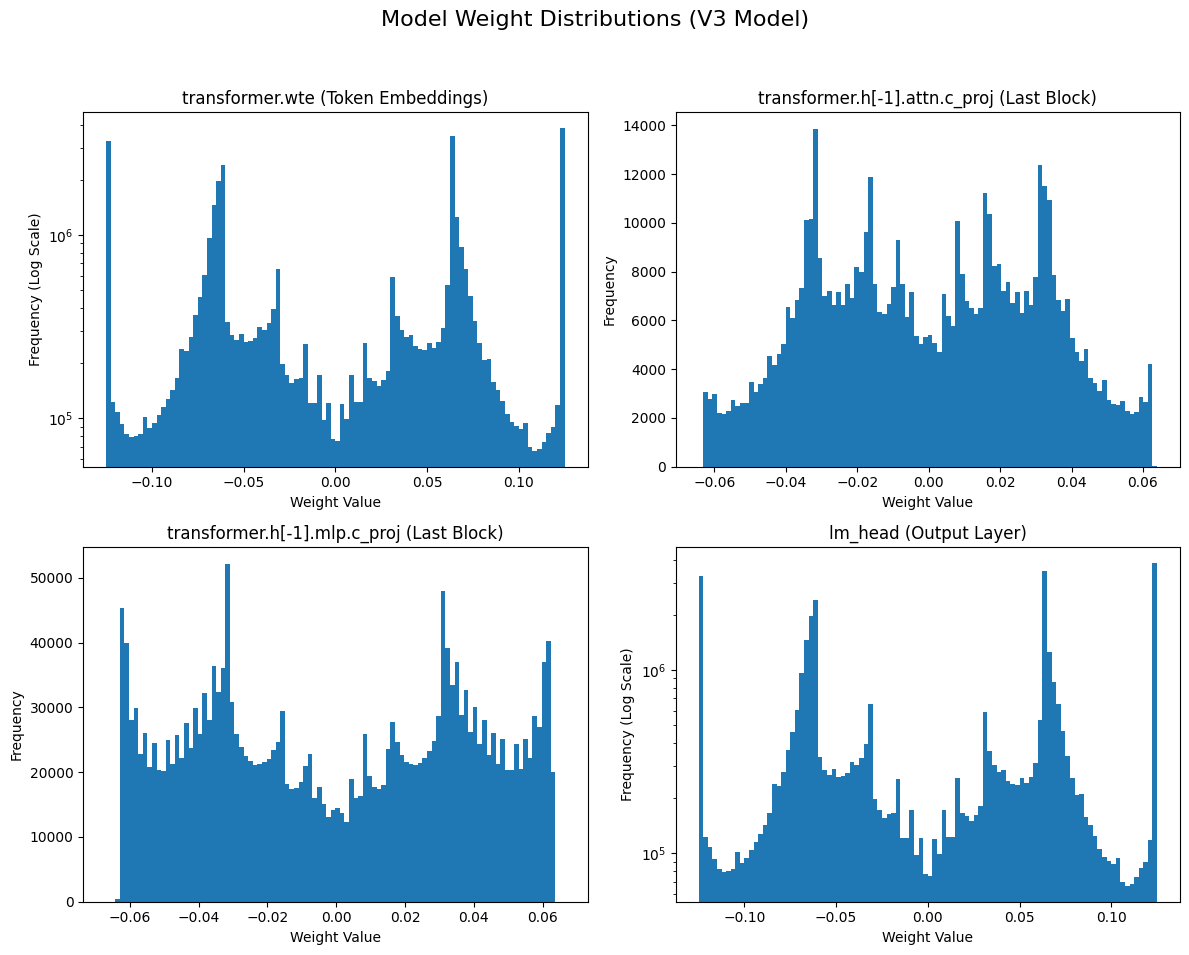